# Licenciatura em Ciências da Computação

## UC Interação e Concorrência 2021/2022

## Grupo 1

Alef Keuffer A91683\
Alexandre Baldé A70373

---

## "*Imports*" e "*utils*"

In [34]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute
from qiskit.tools.visualization import plot_histogram, visualize_transition
import matplotlib.pyplot as plt
import numpy as np

A função abaixo gera "*bitstrings*" de um dado comprimento.\
É necessário para poder confirmar as soluções dos circuitos de oráculos gerados a partir de uma dada fórmula.

In [35]:
def generate_binary_strings(bit_count):
    binary_strings = []
    def genbin(n, bs=''):
        if len(bs) == n:
            binary_strings.append(bs)
        else:
            genbin(n, bs + '0')
            genbin(n, bs + '1')


    genbin(bit_count)
    return binary_strings

generate_binary_strings(4)

['0000',
 '0001',
 '0010',
 '0011',
 '0100',
 '0101',
 '0110',
 '0111',
 '1000',
 '1001',
 '1010',
 '1011',
 '1100',
 '1101',
 '1110',
 '1111']

### Execução de circuito

Nas aulas TP o Professor Sequeira forneceu uma função de execução repetida de circuitos quânticos, que se coloca abaixo.

In [36]:
def execute_circuit(qc, shots=1024, decimal=False):
    
    #define backend
    device = Aer.get_backend('qasm_simulator')
    #get counts
    counts = device.run(qc, shots=shots).result().get_counts()
    
    if decimal:
        counts = dict((int(a[::-1],2),b) for (a,b) in counts.items())
    else:
        counts = dict((a[::-1],b) for (a,b) in counts.items())

    return counts

No entanto, como se recorreu à classe [`PhaseOracle`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.PhaseOracle.html) do Qiskit para criar o oráculo do algoritmo de Grover, classe esta que utiliza "*gates*" não suportadas sem fazer ["*transpilation*"](https://qiskit.org/documentation/stubs/qiskit.compiler.transpile.html) de circuitos, foi necessário modificar a função, cuja versão final se apresenta de seguida.


<a id='exec_circ'></a>

In [37]:
from qiskit.compiler import transpile

def execute_circuit_2(qc, shots=1024, decimal=False):
    # define backend
    device = Aer.get_backend('qasm_simulator')

    # transpile circuit to avoid "unsupported gates" error.
    qc_transpiled = transpile(qc, backend=device)

    # get counts
    counts = device.run(qc_transpiled, shots=shots).result().get_counts()

    if decimal:
        counts = dict((int(a[::-1],2),b) for (a,b) in counts.items())
    else:
        counts = dict((a[::-1],b) for (a,b) in counts.items())

    return counts

---

## Criação de Oráculos e seus circuitos, Difusor e Algoritmo de Grover

Como referido acima, para criar o oráculo necessário ao algoritmo de Grover, a classe `PhaseOracle` permite duas formas de,
a partir de uma fórmula em lógica proposicional, criar um circuito quântico que represente o oráculo que lhe corresponde:

* Através de uma "*string*" que represente a fórmula, e.g. `"v0 | v1 | v2"` para $v_0 \lor v_1 \lor v_2$
* Através de um ficheiro no formato [DIMACS](https://www.cs.utexas.edu/users/moore/acl2/manuals/current/manual/index-seo.php/SATLINK____DIMACS), utilizado frequentemente em SAT-"*solvers*".

Abaixo, implementam-se alguns oráculos para duas fórmulas 3-SAT, e um oráculo para 4-SAT a título experimental.\
Todas as fórmulas têm uma ou mais soluções.

A primeira fórmula abaixo tem 5 soluções $-$ mais que metade do número máximo de soluções para uma fórmula 3-SAT, que é 8 - isto será relevante na análise do circuito para o algoritmo de Grover.

In [38]:
from qiskit.circuit.library import PhaseOracle

threesat_oracle1 = PhaseOracle("(v0 | v1 | ~v2) & (~v0 | ~v1 | ~v2) & (~v0 | v1 | v2)")

O oráculo abaixo corresponde à fórmula $(v_0 \lor v_1 \lor v_2) \land (\lnot v_0 \lor v_1 \lor v_2) \land (v_0 \lor \lnot v_1 \lor \lnot v_2) \land (\lnot v_0 \lor v_1 \lor  \lnot v_2) \land (\lnot v_0 \lor \lnot v_1 \lor \lnot v_2)$, com 3 soluções.

In [39]:
threesat_oracle2 = PhaseOracle("(v0 | v1 | v2) & (~v0 | v1 | v2) & (v0 | ~v1 | ~v2) & (~v0 | v1 | ~v2) & (~v0 | ~v1 | ~v2)")

O oráculo abaixo é carregado de um ficheiro DIMACS com uma fórmula 4-SAT, com 3 soluções.

A fórmula admite a representação:

$$
\begin{alignat*}{5}
&(\lnot v_0 \lor \lnot v_1 \lor \lnot v_2 \lor v_3) & \land \ (v_0 \lor \lnot v_1 \lor v_2 \lor v_3) & \land (v_0 \lor v_1 \lor \lnot v_2 \lor \lnot v_3) & \land (\lnot v_0 \lor v_1 \lor v_2 \lor \lnot v_3)\ &\land \\
&(\lnot v_0 \lor \lnot v_1 \lor \lnot v_2 \lor \lnot v_3) & \land (v_0 \lor v_1 \lor \lnot v_2 \lor v_3) & \land (\lnot v_0 \lor \lnot v_1 \lor v_2 \lor \lnot v_3) & \land (v_0 \lor v_1 \lor v_2 \lor v_3) & \land \\
&(v_0 \lor v_1 \lor v_2 \lor \lnot v_3) & \land (\lnot v_0 \lor v_1 \lor v_2 \lor v_3) & \land (\lnot v_0 \lor v_1 \lor \lnot v_2 \lor v_3) & \land (v_0 \lor \lnot v_1 \lor \lnot v_2 \lor v_3)\ & \land \\
& (\lnot v_0 \lor v_1 \lor \lnot v_2 \lor \lnot v_3)
\end{alignat*}
$$

In [40]:
foursat_oracle1 = PhaseOracle.from_dimacs_file("4sat.dimacs")

### Visualização dos Circuitos

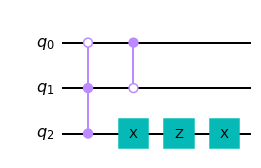

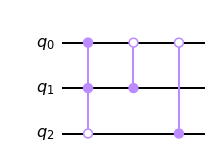

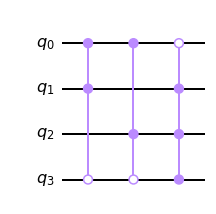

In [41]:
from IPython.display import display

oracle_list = [threesat_oracle1, threesat_oracle2, foursat_oracle1]
for oracle in oracle_list:
    display(oracle.draw(output='mpl'))

Veja-se que os circuitos produzidos por `PhaseOracle` **não** possuem "*ancilla*".

### Contagem de soluções das fórmulas propostas

In [42]:
def count_solutions(oracle_circ):
    k = 0
    for bstr in generate_binary_strings(oracle_circ.num_qubits):
        # A "endianness" da bitstring precisa ser invertida para este método!
        if oracle_circ.evaluate_bitstring(bstr[::-1]):
            k += 1

    return k

Para a fórmula 4-SAT, mostra-se abaixo que só tem 3 soluções, através de [`PhaseOracle.evaluate_bitstring(bitstr : str)`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.PhaseOracle.evaluate_bitstring.html#qiskit.circuit.library.PhaseOracle.evaluate_bitstring).

In [43]:
for bstr in generate_binary_strings(4):
    print(f"evals to {foursat_oracle1.evaluate_bitstring(bstr[::-1])} for: " + bstr)


evals to False for: 0000
evals to False for: 0001
evals to False for: 0010
evals to False for: 0011
evals to False for: 0100
evals to False for: 0101
evals to False for: 0110
evals to True for: 0111
evals to False for: 1000
evals to False for: 1001
evals to True for: 1010
evals to False for: 1011
evals to True for: 1100
evals to False for: 1101
evals to False for: 1110
evals to False for: 1111


Este resultado concorda com a implementação acima de `count_solutions(oracle : circuit)`.

In [44]:
for oracle in oracle_list:
    display(count_solutions(oracle))

5

3

3

### Operador de difusão

Uma versão inicial do operador de difusão foi desenvolvido nas aulas práticas, tendo os autores depois completado a implementação seguindo
uma das [referências dadas no enunciado do projeto](https://qiskit.org/textbook/ch-algorithms/grover.html#3.1-Qiskit-Implementation-).

In [45]:
def diffusion_operator_new(qr):
    qc = QuantumCircuit(qr)

    qc.h(qr)
    qc.x(qr)

    # Apply Hadamard gate to the last qubit.
    qc.h(qr[-1])
    #Multi-control Toffoli gate: every qubit except last is control, target is last qubit.
    qc.mct(qr[:-1], qr[-1])
    # Apply Hadamard gate to the last qubit.
    qc.h(qr[-1])

    qc.x(qr)
    qc.h(qr)

    return qc

## Algoritmo de Grover

In [46]:
from math import sqrt, floor, pi

def my_grover(oracle_circ, iterations = -1):
    # Retirar número de qubits necessários do circuito oráculo
    nqubits = oracle_circ.num_qubits

    # Criar registos quânticos e clássicos.
    qr = QuantumRegister(nqubits, 'q')
    cr = ClassicalRegister(nqubits, 'c')

    qc = QuantumCircuit(qr, cr)

    # Sobreposição uniforme inicial, explicado pelos Professores como primeiro
    # passo do algoritmo de Grover. 
    qc.h(qr)
    qc.barrier()

    # Necessário saber número de soluções da fórmula que gerou o oráculo
    # para iterar oráculo + difusor número correto de vezes.
    k = count_solutions(oracle_circ)
    N = 2**nqubits

    if (iterations == -1):
        iterations = floor(pi/4 * sqrt(N/k))
    for j in range(iterations):
        qc = qc.compose(oracle_circ)
        qc.barrier()
        qc = qc.compose(diffusion_operator_new(qr))

    qc.measure(qr, cr)
    return qc

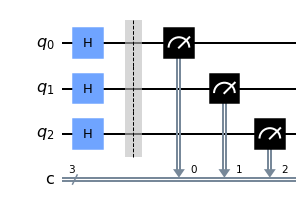

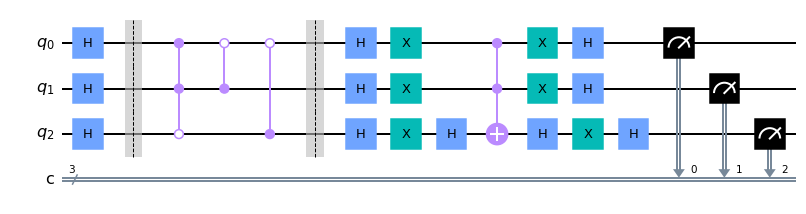

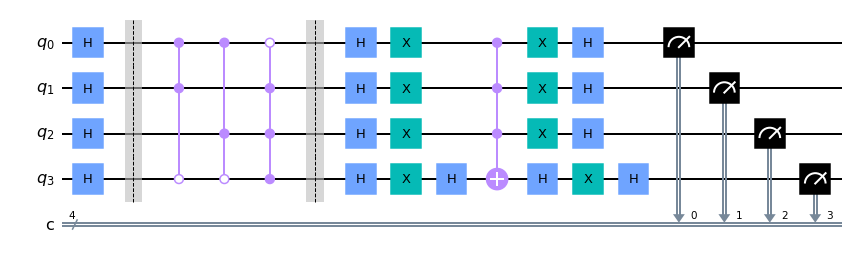

In [47]:
for oracle in oracle_list:
    qc = my_grover(oracle)
    display(qc.draw(output="mpl"))

## Análise dos Resultados

Vejam-se as medições realizadas com [`execute_circuit_2`](#exec_circ) para as três fórmulas, que, recorde-se, são:
* Uma fórmula 3-SAT com 5 soluções, retirada da documentação do Qiskit [dada no enunciado](https://qiskit.org/textbook/ch-applications/satisfiability-grover.html#4.-Problems-): $(x_1∨x_2∨¬x_3)∧(¬x_1∨¬x_2∨¬x_3)∧(¬x_1∨x_2∨x_3)$
* A fórmula 3-SAT com 3 soluções: $(v_0 \lor v_1 \lor v_2) \land (\lnot v_0 \lor v_1 \lor v_2) \land (v_0 \lor \lnot v_1 \lor \lnot v_2) \land (\lnot v_0 \lor v_1 \lor  \lnot v_2) \land (\lnot v_0 \lor \lnot v_1 \lor \lnot v_2)$
* Uma formula 4-SAT com 3 soluções, presente no ficheiro `4sat.dimacs` que acompanha este ficheiro Notebook.

Antes de cada medição aparecerão as soluções que a fórmula do oráculo em causa admite, através do código [anterior](#contagem-de-soluções-das-fórmulas-propostas).

In [48]:
def print_solutions(oracle):
    for bstr in generate_binary_strings(oracle.num_qubits):
        boolean = oracle.evaluate_bitstring(bstr[::-1])
        if boolean:
            print(f"evals to {boolean} for: " + bstr)


In [49]:
# Exemplo de verificar soluções de um oráculo correspondente a uma fórmula.
print_solutions(foursat_oracle1)

evals to True for: 0111
evals to True for: 1010
evals to True for: 1100


---

Para cada um dos circuitos construídos, sumarise-se o processo:
* Construir o circuito para o algoritmo de Grover seguindo as notas [presentes no enunciado](https://qiskit.org/textbook/ch-algorithms/grover.html#Amplitude-Amplification).
* Executar o circuito, tendo o cuidado de utilizar a função `execute_circuit_2` para evitar erros de "*gates*" geradas pelo circuito `PhaseOracle` não suportadas pelo Qiskit
* Mostrar as soluções reais da fórmula recorrendo à função `print_solutions` definida acima
* Mostrar o resultado das medições, e confirmar que concorda com as soluções do problema SAT

evals to True for: 000
evals to True for: 010
evals to True for: 011
evals to True for: 101
evals to True for: 110


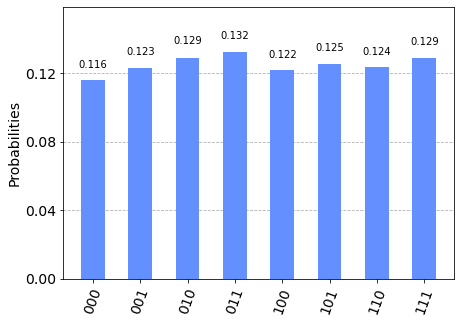

evals to True for: 001
evals to True for: 010
evals to True for: 110


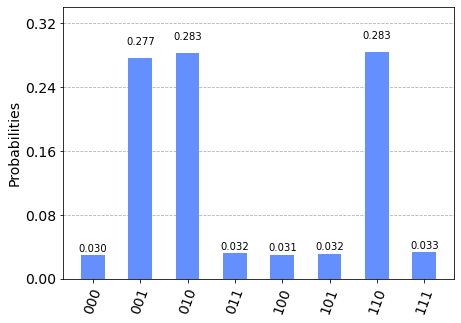

evals to True for: 0111
evals to True for: 1010
evals to True for: 1100


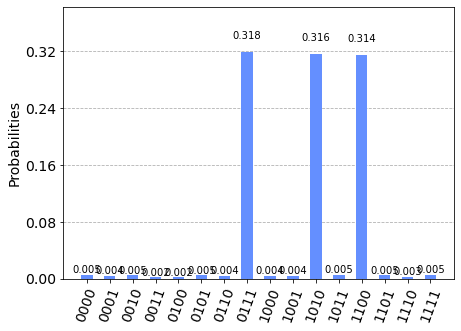

In [50]:
for oracle in oracle_list:
    # Construir circuito de Grover
    qc = my_grover(oracle)
    # Executar circuito
    counts = execute_circuit_2(qc, shots = 4096)
    # Mostrar soluções do problema SAT para a fórmula dada
    print_solutions(oracle)
    # Mostrar resultados de medição
    display(plot_histogram(counts))

---

### Conclusão da experiência acima

* Vê-se que, quando o número de soluções é apropriado $-$ isto é, há menos de $\frac{2^n}{2}$ soluções para um problema $n$-SAT $-$ o algoritmo produz os resultados esperados com precisão, elevada no caso 3-SAT, e muito elevada no caso 4-SAT.
* Quando não é este o caso, como no primeiro oráculo correspondente a uma fórmula 3-SAT com 5 soluções, o algoritmo apresenta resultados **incorretos**.

## Complexidade da solução

No algoritmo de Grover, para uma fórmula $n$-SAT (que dará origem a um oráculo de $n$ qubits) com no máximo
$N = 2^n$ soluções e com $k$ soluções , a complexidade assimptótica é 

$$ 
\mathcal{O}\Bigg(\sqrt{\frac{N}{k}}\Bigg) % Open at top left
$$

Para este algoritmo, também é possível, para além da complexidade assimptótica, [calcular o número exato de aplicações do oráculo e difusor](https://en.wikipedia.org/wiki/Grover%27s_algorithm#Multiple_matching_entries) após a sobreposição uniforme inicial:

$$
\Bigg\lfloor \frac{\pi}{4} \cdot \sqrt{\frac{N}{k}} \Bigg\rfloor
$$

In [51]:
def its(n, k):
    N = 2**n
    return floor(pi/4 * sqrt(N/k))

Para o circuito 3-SAT com 5 soluções, isto dá

In [52]:
its(3, 5)

0

O valor de $0$ iterações previsto acima para um problema de procura com $2^3 = 8$ soluções máximas e $5$ soluções mostra a invalidez do algoritmo de Grover quando as soluções são mais que a metade do espaço de procura.

Para o 3-SAT com 3:

In [53]:
its(3, 3)

1

Para o 4-SAT com 3:

In [54]:
its(4, 3)

1

Veja-se que estes valores $-$ que indicam o número de aplicações do oráculo+difusor no circuito do algoritmo de Grover $-$ observam-se nos circuitos do algoritmo de Grover para cada um dos oráculos presentes [acima](#algoritmo-de-grover).

Para verificar empiricamente a previsão do número de iterações,
* teste-se retirar uma solução possível do 4-SAT
* construa-se o novo circuito oráculo,
* construa-se também um novo circuito Grover, e
* meça-se o resultado do algoritmo com o novo oráculo

Recorde-se que, como previsto acima, o circuito do algoritmo de Grover para a fórmula 4-SAT de 3 soluções tem uma só aplicação do oráculo/difusor:

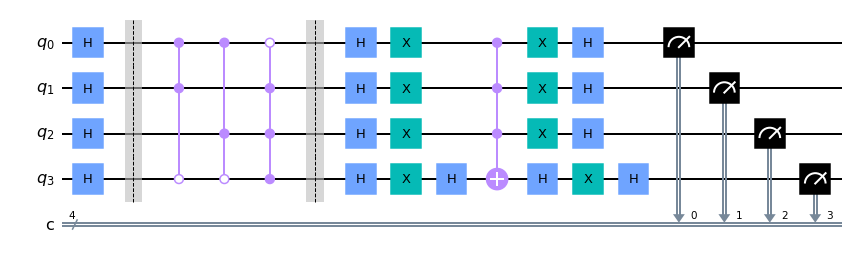

In [55]:
qc = my_grover(foursat_oracle1)
display(qc.draw(output="mpl"))

In [56]:
print_solutions(foursat_oracle1)

evals to True for: 0111
evals to True for: 1010
evals to True for: 1100


Adicione-se a um novo ficheiro `4sat_2.dimacs` a cláusula `-1 -2 3 4 0`, que corresponderá a $(\lnot v_1 \lor \lnot v_2 \lor v_3 \lor v_4)$, e que cancelará a solução `1100` acima.

In [57]:
foursat_oracle2 = PhaseOracle.from_dimacs_file("4sat_2.dimacs")

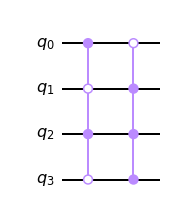

In [58]:
display(foursat_oracle2.draw(output='mpl'))

A previsão teórica do número de iterações para 4-SAT com 2 soluções:

In [59]:
its(4, 2)

2

Observe-se agora o novo circuito de Grover para o novo oráculo 4-SAT que só admite 2 soluções:

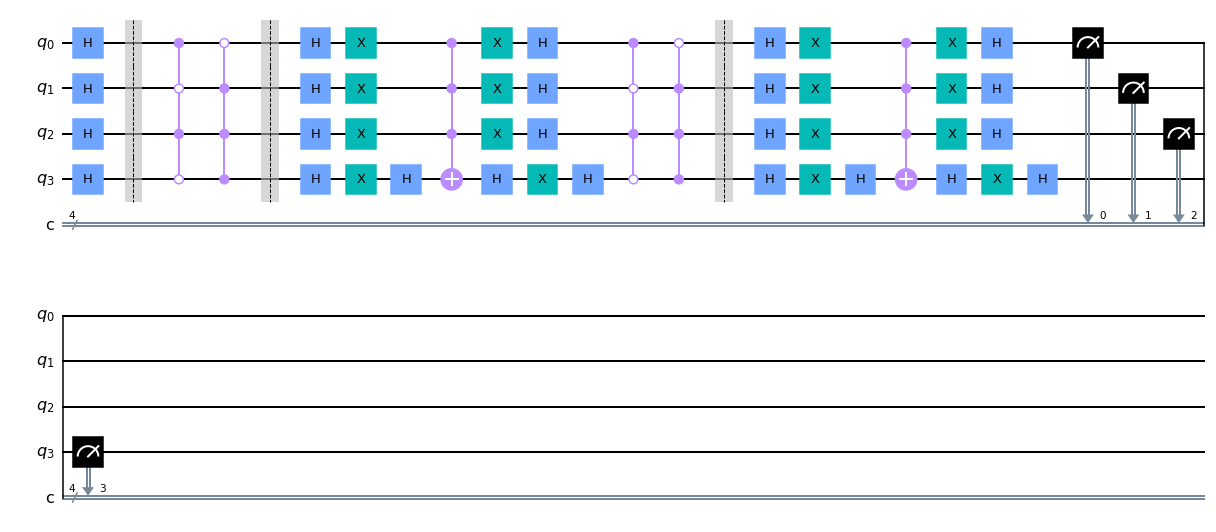

In [60]:
qc = my_grover(foursat_oracle2)
display(qc.draw(output="mpl"))

Como previsto, há agora duas iterações do oráculo/difusor.

Finalmente, meça-se os resultados, podendo-se confirmar na prática a previsão teórica.

evals to True for: 0111
evals to True for: 1010


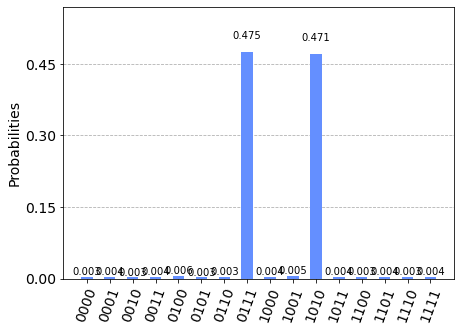

In [61]:
# Construir circuito de Grover
qc = my_grover(foursat_oracle2)
# Executar circuito
counts = execute_circuit_2(qc, shots = 4096)
# Mostrar soluções do problema SAT para a fórmula dada
print_solutions(foursat_oracle2)
# Mostrar resultados de medição
display(plot_histogram(counts))

---

A título de curiosidade, experimente-se o algoritmo de Grover para este 4-SAT com 2 soluções, utilizando números diferentes de iterações, e observe-se o comportamento da implementação.

Iterações de oráculo + difusor: 0


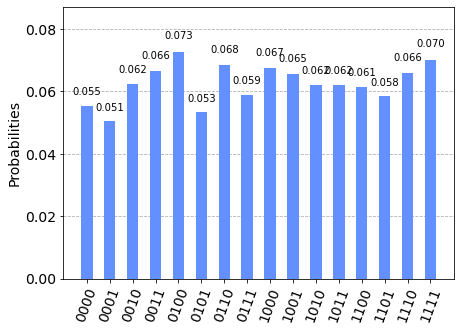

Iterações de oráculo + difusor: 1


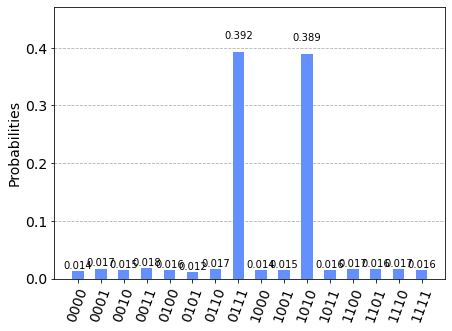

Iterações de oráculo + difusor: 2


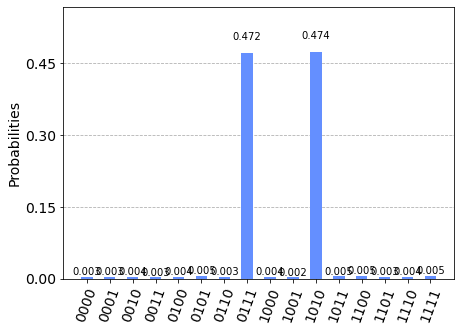

Iterações de oráculo + difusor: 3


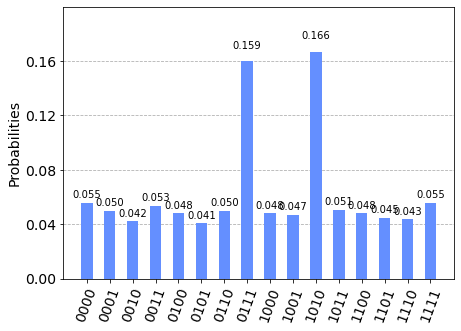

Iterações de oráculo + difusor: 4


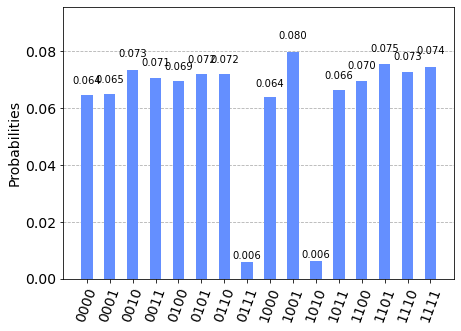

Iterações de oráculo + difusor: 5


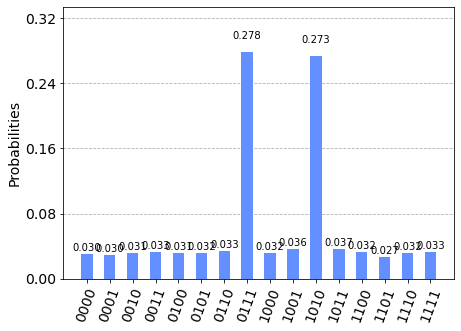

Iterações de oráculo + difusor: 6


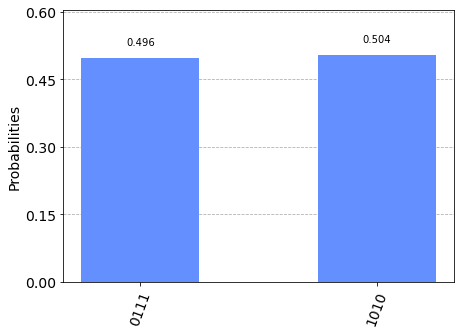

Iterações de oráculo + difusor: 7


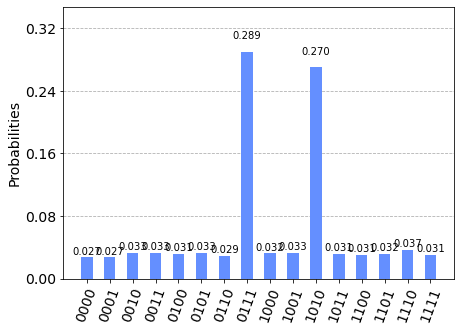

Iterações de oráculo + difusor: 8


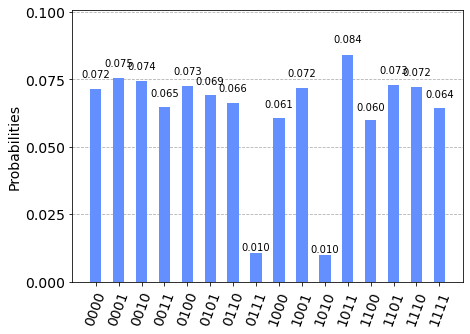

Iterações de oráculo + difusor: 9


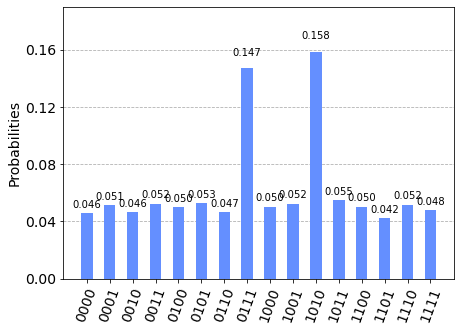

Iterações de oráculo + difusor: 10


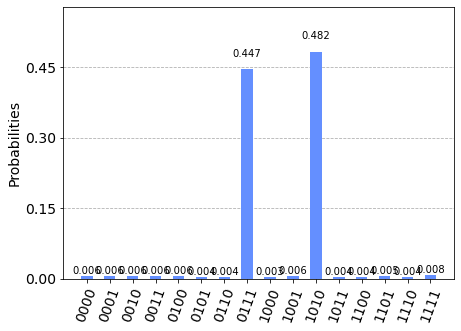

In [62]:
for i in range(0, 11):
    # Construir circuito de Grover
    qc = my_grover(foursat_oracle2, iterations=i)
    # Executar circuito
    counts = execute_circuit_2(qc, shots = 4096)
    print(f"Iterações de oráculo + difusor: {i}")
    # Mostrar resultados de medição
    display(plot_histogram(counts))

Note-se a periodicidade na oscilação da amplitude das soluções, o que está de acordo com o previsto pelo [modelo que se estudou nas aulas TP](https://qiskit.org/textbook/ch-algorithms/grover.html#Amplitude-Amplification), em que cada iteração do oráculo do difusor faz o seguinte:

![image4](img/grover.png)